In [1]:
import torch            		# 导入 torch
import torch.nn as nn     		#  torch的网络组建
import torch.nn.functional as F	#  搭建网络
import torch.optim as optim		# 优化器
import torchvision				# 数据相关
from torchvision import transforms  # 数据处理与增强
import time
import copy
import warnings 
import matplotlib.pyplot as plt 
import numpy as np
from skimage import io
import skimage.transform as tr
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [2]:
train_dir = '../data/datasets/train/'
test_dir = '../data/datasets/test/'

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),       #  输入尺寸
    transforms.RandomCrop((224,224)),  #  裁剪尺寸
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.ColorJitter(
        brightness=(0.7,1.3),  # 明暗程度
        contrast=(0.7,1.3),    # 对比度
        saturation=(0.7,1.3),  # 饱和度
        hue=(-0.05,0.05)),     # 颜色
    transforms.ToTensor(),    # 数据转为张量并做归一化
    transforms.Normalize(   # 数据标准化
        mean = [0.485,0.456,0.406],    # RGB均值
        std = [0.229,0.224,0.225])      # RGB 方差  （可以使用经验值（查阅））
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),   # 输入尺寸（在预测中应遵循此尺寸）
    transforms.ToTensor(),         # 张量      
    transforms.Normalize(         # 标准化
        mean = [0.485,0.456,0.406],
        std = [0.229,0.224,0.225])
])

In [4]:
train_ds = torchvision.datasets.ImageFolder(
    train_dir,    # 导入训练文件夹路径
    transform=train_transform  # 数据处理与增强
)
test_ds = torchvision.datasets.ImageFolder(
    test_dir,     # 导入测试文件夹路径
    transform=test_transform   # 数据处理与增强

)
# 创建dl
BATCHSIZE = 8  # batch_size的批量尺寸
train_dl = torch.utils.data.DataLoader(
    train_ds,   # 将打包好的数据生成可迭代的batch_size个数的批量数据
    batch_size=BATCHSIZE,  # batch_size 值得选择应对照本机配置
    shuffle=True   # 打乱（必须打乱否则模型会识别顺序）
)
test_dl = torch.utils.data.DataLoader(
    test_ds,      
    batch_size=BATCHSIZE
)

In [5]:
model = torchvision.models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# model.features.pool0.kernel_size=2
#model.fc.out_features = 9 #设置cat dog的分类
# 冻结 卷积基 操作
for param in model.parameters():
    param.requires_grad = False
model.fc=nn.Linear(model.fc.in_features,256)
model.add_module('fc_relu',nn.ReLU(inplace=True))
model.add_module('fc_dp',nn.Dropout(p=0.5, inplace=False))
model.add_module('fc1',nn.Linear(256,256))
model.add_module('fc1_relu',nn.ReLU(inplace=True))
model.add_module('fc1_dp',nn.Dropout(p=0.5, inplace=False))
model.add_module('fc2',nn.Linear(256,9))
# model.add_module('fc1_relu',nn.ReLU(inplace=True))
# # model.add_module('fc1_dp',nn.Dropout(p=0.5, inplace=False))

# model.fc=nn.Linear(model.fc.in_features,9)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
# 搭建训练步骤
def train(dataloader,model,loss_fn,optimizer):
    # acc 当前样本一共有多少个
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # 初始化loss值
    train_loss,correct = 0,0
    model.train()  # 模式为训练模式
    for X,y in dataloader:
        # 前向传播（推理）
        X,y = X.to(device),y.to(device)
        pred = model(X)
        # 产生误差
        loss = loss_fn(pred,y)  # 返回平均误差
        # loss = torch.nn.functional.cross_entropy(pred, y)
        # 归零权重(固定写法)
        optimizer.zero_grad()
        # 反向传递
        loss.backward()
        # 利用梯度下降优化参数
        optimizer.step()
        # # 放弃张量微分的追踪（小验证）
        with torch.no_grad():
            train_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    exp_lr_scheduler.step()
    lr_res = optimizer.state_dict()['param_groups'][0]['lr']
    correct /= size        
    train_loss /= num_batches
    return train_loss,correct,lr_res

In [9]:
# 搭建测试 （test）
def test(dataloader,model):
    # acc 当前样本一共有多少个
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss,correct = 0,0
    model.eval()  # 推理模式
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= size        
    test_loss /= num_batches
    return test_loss,correct

In [10]:
best_model_wts = copy.deepcopy(model.state_dict()) # 用以记录模型最优参数
best_acc = 0.0
epochs = 50
train_acc = []
train_loss = []
test_acc = []
test_loss = []
for epoch in range(epochs):
    start  =  time.time()
    epoch_loss,epoch_acc,lr = train(dataloader=train_dl,model=model,loss_fn=loss_fn,optimizer=optimizer)
    epoch_test_loss,epoch_test_acc = test(dataloader=test_dl,model=model)
    end = time.time()
    times = end - start 
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    print('训练epoch{},训练集损失值:{:.2f},训练集的准确率:{:.2f}%,测试集损失值:{:.2f},测试集的准确率:{:.2f}%,当前学习率:{},消耗时间：{:.2f}s'.
          format(epoch+1,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100,lr,times))
    # 保存best——model
    if epoch_test_acc > best_acc:  # 如果当前的test_acc 高于best_acc 执行保存
        best_acc = epoch_test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
print('训练结束并保存最好权重模型')

训练epoch1,训练集损失值:1.60,训练集的准确率:50.69%,测试集损失值:0.68,测试集的准确率:83.69%,当前学习率:0.0001,消耗时间：156.34s
训练epoch2,训练集损失值:1.01,训练集的准确率:69.74%,测试集损失值:0.49,测试集的准确率:85.25%,当前学习率:0.0001,消耗时间：156.35s
训练epoch3,训练集损失值:0.85,训练集的准确率:73.53%,测试集损失值:0.42,测试集的准确率:86.59%,当前学习率:0.0001,消耗时间：156.63s
训练epoch4,训练集损失值:0.79,训练集的准确率:75.07%,测试集损失值:0.39,测试集的准确率:86.72%,当前学习率:0.0001,消耗时间：157.20s
训练epoch5,训练集损失值:0.75,训练集的准确率:75.66%,测试集损失值:0.36,测试集的准确率:88.20%,当前学习率:0.0001,消耗时间：154.61s
训练epoch6,训练集损失值:0.72,训练集的准确率:76.23%,测试集损失值:0.32,测试集的准确率:89.20%,当前学习率:0.0001,消耗时间：154.83s
训练epoch7,训练集损失值:0.70,训练集的准确率:77.21%,测试集损失值:0.33,测试集的准确率:89.11%,当前学习率:0.0001,消耗时间：155.08s
训练epoch8,训练集损失值:0.68,训练集的准确率:77.43%,测试集损失值:0.33,测试集的准确率:89.11%,当前学习率:0.0001,消耗时间：154.38s
训练epoch9,训练集损失值:0.67,训练集的准确率:77.61%,测试集损失值:0.32,测试集的准确率:90.11%,当前学习率:0.0001,消耗时间：154.83s
训练epoch10,训练集损失值:0.66,训练集的准确率:78.15%,测试集损失值:0.32,测试集的准确率:89.15%,当前学习率:0.0001,消耗时间：154.78s
训练epoch11,训练集损失值:0.65,训练集的准确率:78.29%,测试集损失值:0.28,测试集的准确率:91.11%,当前学习率:0.0001,消耗时间：154.67s
训练epoch12,训练集损失值:0.

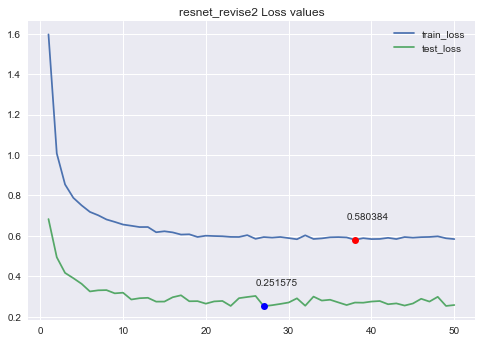

In [62]:
## 训练曲线可视化
# 损失值
train_loss_min_index = np.argmin(np.array(train_loss))
train_loss_min_value = round(train_loss[train_loss_min_index],6)
# test_loss = torch.stack(test_loss).cpu().numpy()
test_loss_min_index = np.argmin(test_loss)
test_loss_min_value = round(test_loss[test_loss_min_index],6)

s = train_loss_min_value
s_test = test_loss_min_value
plt.plot(range(1,51),train_loss,label='train_loss')
plt.plot(range(1,51),test_loss,label='test_loss')
plt.text(train_loss_min_index, train_loss_min_value+0.1, s)
plt.text(test_loss_min_index, test_loss_min_value+0.1, s_test)
plt.plot(train_loss_min_index+1,train_loss_min_value,'ro')
plt.plot(test_loss_min_index+1,test_loss_min_value,'bo')
plt.title('resnet_revise2 Loss values')
plt.legend()

plt.savefig('../resnet1/resnet_revise2_loss')

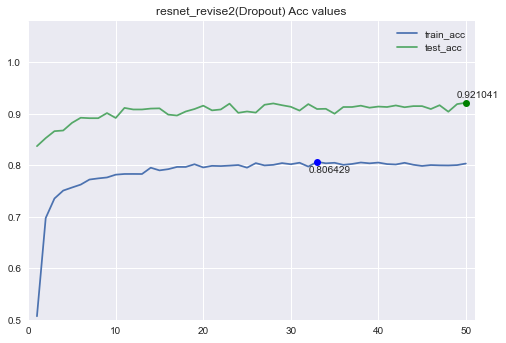

In [63]:
## 训练曲线可视化
# 准确率
train_acc_max_index = np.argmax(np.array(train_acc))
train_acc_max_value = round(train_acc[train_acc_max_index],6)
test_acc_max_index = np.argmax(np.array(test_acc))
test_acc_max_value = round(test_acc[test_acc_max_index],6)

s = train_acc_max_value
s_test = test_acc_max_value
plt.plot(range(1,epoch+2),train_acc,label='train_acc')
plt.plot(range(1,epoch+2),test_acc,label='test_acc')
plt.text(train_acc_max_index, train_acc_max_value-0.02, s)
plt.text(test_acc_max_index, test_acc_max_value+0.01, s_test)
plt.plot(train_acc_max_index+1,train_acc_max_value,'bo')
plt.plot(test_acc_max_index+1,test_acc_max_value,'go')
plt.title('resnet_revise2(Dropout) Acc values')
plt.ylim(0.5,1.08)
plt.xlim(0,51)
plt.legend()
plt.savefig('../resnet1/resnet_revise2_acc')

In [58]:
torch.save(model.state_dict(),'resnet_revise1.pth')